# TP2: Security of Artificial Intelligence Hands-on Session 1: Understanding Basic Evasion Attacks

In [1]:
print(f"""
        Élève         : Vinicius Nascimento
        Num Étudiant  : 00A01916
        Date          : 06 avril 2025
        Classe        : Introduction a Securite des Intelligence Artificielle
        École         : ENSICAEN
        Formation     : CyIA Informatique 2eme année
""")


        Élève         : Vinicius Nascimento
        Num Étudiant  : 00A01916
        Date          : 06 avril 2025
        Classe        : Introduction a Securite des Intelligence Artificielle
        École         : ENSICAEN
        Formation     : CyIA Informatique 2eme année



### Objectives:

• Learn to load and use a pre-trained image classification model in PyTorch. • Understand the Fast Gradient Sign Method (FGSM) attack.\
• Generate adversarial examples that fool the model.\
• Experiment with different perturbation magnitudes.

In [2]:
#Ce bloc contient tous les imports nécessaires pour ce TP.

# import fonction d'affichage
import matplotlib

# import torch
import torch

#import torchvision
import torchvision
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import json
import urllib.request

In [3]:
# model = models.resnet18(pretrained=True) # Pretrained was deprecated, I was adviced to use weights
model = models.resnet18(weights=True)
model.eval() # Important: Set the model to evaluation mode
# it disables dropout and other training-specific behaviors.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 55.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
def load_and_preprocess_image(image_path):
    """Loads an image, pre-processes it, and returns a PyTorch tensor."""
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image)
    return image.unsqueeze(0)  # Add a batch dimension

def imshow(img):
    """ Helper function to display an image.
            img = receive a object image return by load_and_preprocess_image function;
    """
    img = img.clone()
    img -= torch.min(img)
    img /= torch.max(img)
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

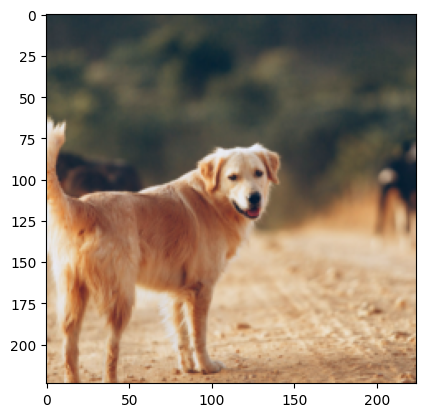

In [16]:
image = load_and_preprocess_image("dog.jpg") # Replace with your image path imshow(image[0])
imshow(image[0])

In [17]:
# Making Predictions
## Functions declarations

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"

response = urllib.request.urlopen(url)
labels = [line.strip() for line in response.readlines()]

def predict(image, model, topk=5):
    """ Predicts the top k classes for a given image.
            image   : tensor with data image;
            model   : type model used;
            topk    : optional parameter that specifies how many top predictions you want to receive;
    """
    with torch.no_grad(): # Disable gradient calculation for inference
        output = model (image)
        probabilities = torch.nn.functional.softmax(output[0],dim=0)
        topk_prob, topk_catid = torch . topk ( probabilities , topk)

        for i in range(topk):
            print(f" Prediction {i+1} : {topk_catid[i].item()} (Probability : {topk_prob[i].item():.4f} {labels[topk_catid[i].item()]})")

    return topk_prob , topk_catid

In [18]:
probs, classes = predict(image, model)

 Prediction 1 : 207 (Probability : 0.7028 b'golden retriever')
 Prediction 2 : 208 (Probability : 0.0535 b'Labrador retriever')
 Prediction 3 : 185 (Probability : 0.0516 b'Norfolk terrier')
 Prediction 4 : 212 (Probability : 0.0188 b'English setter')
 Prediction 5 : 213 (Probability : 0.0166 b'Irish setter')


## Fast Gradient Sign Method (FGSM) Attack

In [28]:
def fgsm_attack(image, epsilon, model, target=None): # added target
    """ Generates an adversarial example using the FGSM attack.
          image   : Input image tensor to be perturbed.
          epsilon : Perturbation magnitude (controls the strength of the attack).
          model   : Neural network model used to compute gradients.
          target  : (Optional) Target label for a targeted attack. If None, performs untargeted attack.
    """
    targeted = False
    if target is None:
        target = np.random.randint(0, len(labels))
        print(f"Target is equal none. New randomic target = {target} thats represent {labels[target]}")
    else:
        # Targeted attack: use specified incorrect label
        if isinstance(target, int):
            target = torch.tensor([target])
        targeted = True

    target = torch.tensor([target])

    # Forward pass through the model to compute output
    output = model(image)

    output = model(image)
    loss = torch.nn.functional.cross_entropy(output,target)

    # Avoid grad acumulation, clear
    model.zero_grad()
    # Backpropagate to compute gradients
    loss.backward()

    image_grad = image.grad.data

    # Use cross-entropy loss. TARGET MUST BE A LONG TENSOR (INTEGER)
    if targeted:
        adv_img = image - epsilon * image_grad.sign()
    else:
        adv_img = image + epsilon * image_grad.sign()

    return adv_img

Target is equal none. New randomic target = 37 thats represent b'box turtle'
Correct Model : 


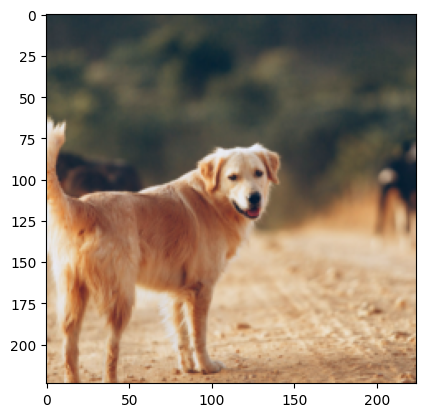

 Prediction 1 : 207 (Probability : 0.7028 b'golden retriever')
 Prediction 2 : 208 (Probability : 0.0535 b'Labrador retriever')
 Prediction 3 : 185 (Probability : 0.0516 b'Norfolk terrier')
 Prediction 4 : 212 (Probability : 0.0188 b'English setter')
 Prediction 5 : 213 (Probability : 0.0166 b'Irish setter')
Perturbed Model : 


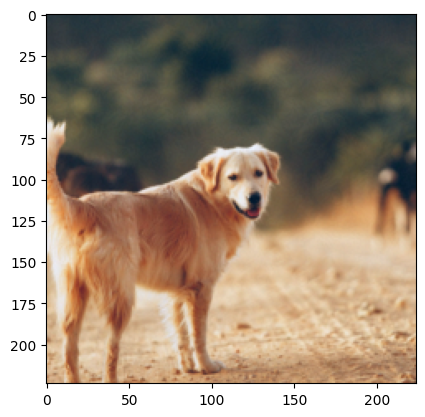

 Prediction 1 : 207 (Probability : 0.9915 b'golden retriever')
 Prediction 2 : 208 (Probability : 0.0060 b'Labrador retriever')
 Prediction 3 : 222 (Probability : 0.0004 b'kuvasz')
 Prediction 4 : 213 (Probability : 0.0004 b'Irish setter')
 Prediction 5 : 176 (Probability : 0.0004 b'Saluki')


In [40]:
perturbed_image = fgsm_attack(image, 0.02, model)

print("Correct Model : ")
imshow(image[0])
probs, classes = predict(image, model)

print("Perturbed Model : ")
imshow(perturbed_image[0])
probs, classes = predict(perturbed_image, model)

In [41]:
def quantize(data, bits=8):
    """Quantize image to a specified bit depth."""
    levels = 2 ** bits
    data_min = data.min()
    data_max = data.max()

    # Normalize data to [0,1]
    normalized = (data - data_min) / (data_max - data_min)
    # Quantize to discrete levels
    quantized = torch.round(normalized * (levels - 1)) / (levels - 1)
    # Rescale back to original range
    quantized_data = quantized * (data_max - data_min) + data_min

    return quantized_data

In [42]:
def score_change(model, data, quantized_data, target):
    model.eval()
    # Calculate the change in the model ’s output probabilities
    with torch.no_grad():
        output_original = model(data)
        prob_original = F.softmax(output_original, dim=1)  # Convert to probabilities

        output_quantized = model(quantized_data)
        prob_quantized = F.softmax(output_quantized, dim=1)
    # to be completed
    # Ensure model is in evaluation mode
    if target is None:
            target = torch.argmax(prob_original, dim=1)

    # Get the probabilities for the correct class
    original_confidence = prob_original.gather(1, target.unsqueeze(1)).squeeze()
    quantized_confidence = prob_quantized.gather(1, target.unsqueeze(1)).squeeze()

    # Compute absolute change in confidence
    change = torch.abs(original_confidence - quantized_confidence)

    return change

Normal model:
 Prediction 1 : 207 (Probability : 0.7028 b'golden retriever')
 Prediction 2 : 208 (Probability : 0.0535 b'Labrador retriever')
 Prediction 3 : 185 (Probability : 0.0516 b'Norfolk terrier')
 Prediction 4 : 212 (Probability : 0.0188 b'English setter')
 Prediction 5 : 213 (Probability : 0.0166 b'Irish setter')
Quantized image:


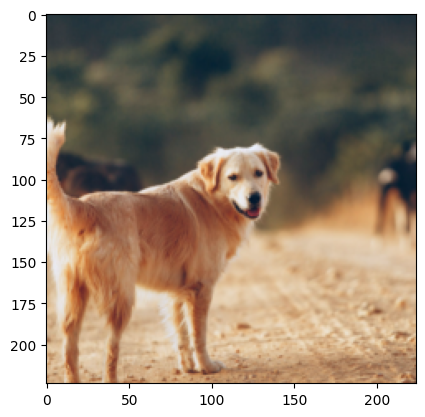

 Prediction 1 : 207 (Probability : 0.7029 b'golden retriever')
 Prediction 2 : 208 (Probability : 0.0535 b'Labrador retriever')
 Prediction 3 : 185 (Probability : 0.0516 b'Norfolk terrier')
 Prediction 4 : 212 (Probability : 0.0188 b'English setter')
 Prediction 5 : 213 (Probability : 0.0166 b'Irish setter')


In [43]:
print("Normal model:")
probs, classes = predict(image, model)

print("Quantized image:")
quantized_image = quantize(image, 16)
imshow(quantized_image[0])
probs, classes = predict(quantized_image, model)

In [48]:
print("Quantized image:")
for bits in [1, 2, 4, 6, 8, 16]:
    quantized_image = quantize(image, bits)
    change = score_change(model, image, quantized_image, target=None)
    print(f"Bits: {bits}, Score change: {change.item():.4f}")

Quantized image:
Bits: 1, Score change: 0.5844
Bits: 2, Score change: 0.4722
Bits: 4, Score change: 0.1218
Bits: 6, Score change: 0.0225
Bits: 8, Score change: 0.0052
Bits: 16, Score change: 0.0000


In [50]:
print("Quantized image:")
for bits in [1, 2, 4, 6, 8, 16]:
    quantized_modify_image = quantize(perturbed_image, bits)
    change = score_change(model, perturbed_image, quantized_modify_image, target=None)
    print(f"Bits: {bits}, Score change: {change.item():.4f}")

Quantized image:
Bits: 1, Score change: 0.8456
Bits: 2, Score change: 0.8109
Bits: 4, Score change: 0.0515
Bits: 6, Score change: 0.0012
Bits: 8, Score change: 0.0004
Bits: 16, Score change: 0.0000


In [52]:
change_scores = score_change(model, image, quantized_image, target=None)
print(f"Score change after quantization : {change_scores.item():.4f}")
threshold = 0.1
if change_scores > threshold :
    print ("Potential adversarial example detected!")
else :
    print ("Likely a clean example.")

# probs, classes = predict(perturbed_image, model)

Score change after quantization : 0.0000
Likely a clean example.


**[Vinicius]** Reducing the number of bits per pixel affects the model's confidence in its predictions. When testing with a clean image, we observed that lower bit depths (e.g., 1 or 2 bits) caused a significant change in the model's output confidence. This indicates that aggressive quantization introduces too much distortion.

I found that from 4 bits and below, the score change becomes noticeable even for clean images, meaning the model starts losing prediction reliability. From 6 bits and above, the model remains robust and the quantization does not affect the prediction significantly.

The score change is much higher for adversarial examples than for clean ones after quantization. This difference can be used to detect adversarial inputs.

I suggest using a threshold, such as 0.1, to distinguish clean images from potential adversarial ones based on the change in confidence.

In [72]:
# [Vinicius]: Fixing the previous function to work correctly
def fgsm_attack(image, epsilon, model, target=None):
    image = image.clone().detach().requires_grad_(True)

    output = model(image)

    targeted = False
    if target is None:
        target = output.max(1)[1]
        print(f"Target is equal none. New randomic target = {target.item()} thats represent {labels[target.item()]}")
    else:
        targeted = True
        if isinstance(target, int):
            target = torch.tensor([target])
        elif target.dim() == 0:
            target = target.unsqueeze(0)

    loss = torch.nn.functional.cross_entropy(output, target)

    model.zero_grad()
    loss.backward()  # Added this

    image_grad = image.grad.data

    if targeted:
        perturbed_image = image - epsilon * image_grad.sign()
    else:
        perturbed_image = image + epsilon * image_grad.sign()

    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image.detach()

In [67]:
import random
from torchvision.transforms import functional as F

def random_translation(image, max_translation=5):
    dx = random.randint(-max_translation, max_translation)
    dy = random.randint(-max_translation, max_translation)
    translated = F.affine(image.squeeze(0), angle=0, translate=[dx, dy], scale=1.0, shear=[0.0, 0.0])
    return translated.unsqueeze(0)

def evaluate_with_randomization(model, image, attack=None, epsilon=0.0, max_translation=5):
    model.eval()

    # Apply attack if needed
    if attack is not None:
        image = attack(image, epsilon, model)

    # Apply random translation
    translated_image = random_translation(image, max_translation)

    with torch.no_grad():
        output = model(translated_image)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        top1_prob, top1_idx = torch.max(probabilities, 0)

    return top1_idx.item(), top1_prob.item(), translated_image

[Vinicius] Clean image prediction after translation: 207 (b'golden retriever') with prob 0.8426


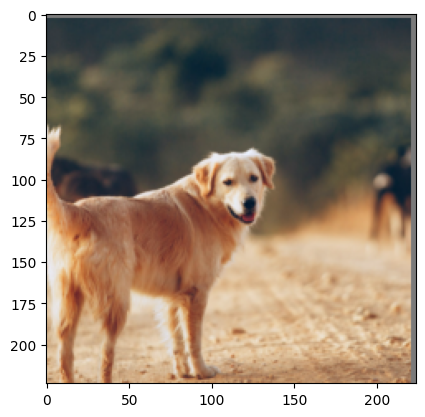

Target is equal none. New randomic target = 207 thats represent b'golden retriever'
[Vinicius] Adversarial image prediction after translation: 354 (b'Arabian camel') with prob 0.0755


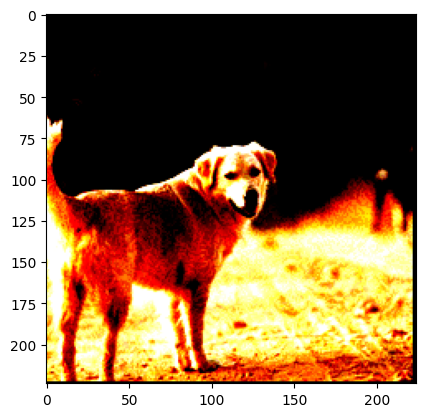

In [73]:
image = load_and_preprocess_image("dog.jpg")

# Clean prediction with translation
label, prob, translated_image = evaluate_with_randomization(model, image, attack=None, max_translation=3)
print(f"[Vinicius] Clean image prediction after translation: {label} ({labels[label]}) with prob {prob:.4f}")
imshow(translated_image[0])

# Adversarial prediction with translation
adv_label, adv_prob, adv_translated_image = evaluate_with_randomization(model, image, attack=fgsm_attack, epsilon=0.1, max_translation=3)
print(f"[Vinicius] Adversarial image prediction after translation: {adv_label} ({labels[adv_label]}) with prob {adv_prob:.4f}")
imshow(adv_translated_image[0])

In [74]:
for max_t in [0, 2, 4, 6, 8]:
    print(f"\nTesting max_translation = {max_t}")

    # Clean
    label_clean, prob_clean, _ = evaluate_with_randomization(
        model, image, attack=None, max_translation=max_t
    )
    print(f"Clean image → Class: {label_clean} ({labels[label_clean]}), Prob: {prob_clean:.4f}")

    # Adversarial
    label_adv, prob_adv, _ = evaluate_with_randomization(
        model, image, attack=fgsm_attack, epsilon=0.1, max_translation=max_t
    )
    print(f"Adversarial image → Class: {label_adv} ({labels[label_adv]}), Prob: {prob_adv:.4f}")



Testing max_translation = 0
Clean image → Class: 207 (b'golden retriever'), Prob: 0.7028
Target is equal none. New randomic target = 207 thats represent b'golden retriever'
Adversarial image → Class: 38 (b'banded gecko'), Prob: 0.1561

Testing max_translation = 2
Clean image → Class: 207 (b'golden retriever'), Prob: 0.6951
Target is equal none. New randomic target = 207 thats represent b'golden retriever'
Adversarial image → Class: 211 (b'vizsla'), Prob: 0.0928

Testing max_translation = 4
Clean image → Class: 207 (b'golden retriever'), Prob: 0.7807
Target is equal none. New randomic target = 207 thats represent b'golden retriever'
Adversarial image → Class: 234 (b'Rottweiler'), Prob: 0.0622

Testing max_translation = 6
Clean image → Class: 207 (b'golden retriever'), Prob: 0.7986
Target is equal none. New randomic target = 207 thats represent b'golden retriever'
Adversarial image → Class: 234 (b'Rottweiler'), Prob: 0.0958

Testing max_translation = 8
Clean image → Class: 207 (b'golden

**[Vinicius]**

As the `max_translation` increases, the model becomes more robust to adversarial examples, since the perturbation is crafted for a specific position. However, too much translation starts to hurt the accuracy on clean images, because the object may move out of the focus area. So, there’s a tradeoff: more robustness vs. less clean accuracy.

## **Adversarial Training Implementation**
This is the core of the session. We’ll create a simplified training loop.
Defining a Simpler Model:
To speed up training, we’ll define a smaller, simpler CNN model. Here’s an example:

In [77]:
import torch
import torch.nn as nn

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10) # Assuming 10 classes (e.g., CIFAR -10)

  def forward(self, x):
    x = self.pool(torch.nn.functional.relu(self.conv1(x)))
    x = self.pool(torch.nn.functional.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = SimpleCNN ()

### Loading and Preparing Data:
We’ll use a small subset of CIFAR-10 for training.

In [78]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download =True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size =4, shuffle=True, num_workers=2) # use small dataset

testset = torchvision.datasets.CIFAR10(root='./data', train =False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane' , 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Defining Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # learning rate


In [81]:
# Implementing the Training Loop:
# Here’s the core training loop. Study it carefully!

import torch.nn.functional as F

num_epochs = 3  # [Vinicius] Reduced from 5 to 3 to speed up training
max_batches = 500  # [Vinicius] Limited to 500 batches per epoch to reduce training time

for epoch in range(num_epochs):
    for i, (data, target) in enumerate(trainloader):
        if i >= max_batches:
            break  # [Vinicius] Stop early after max_batches

        # Generate adversarial examples
        epsilon = 0.1
        data_adv = fgsm_attack(data, epsilon, model, target)

        # Combine original and adversarial data
        combined_data = torch.cat((data, data_adv), 0)
        combined_target = torch.cat((target, target), 0)

        # Train on the combined batch
        optimizer.zero_grad()
        output = model(combined_data)
        loss = criterion(output, combined_target)
        loss.backward()
        optimizer.step()

        if i % 200 == 199:  # [Vinicius] Print more frequently due to fewer batches
            print(f'[{epoch+1}, {i+1:5d}] loss: {loss.item():.3f}')


[1,   200] loss: 0.697
[1,   400] loss: 0.340
[2,   200] loss: 1.193
[2,   400] loss: 0.363
[3,   200] loss: 0.419
[3,   400] loss: 1.043


### Evaluating the Defense
Now, let’s see how well our adversarially trained model performs.
Evaluation on Clean and Adversarial Examples:
Write functions to evaluate the model’s accuracy on both clean images and adversarial images.

In [86]:
def fgsm_attack_batch(image, epsilon, model, target): # My attack was developped just for one loaded image
    image = image.clone().detach().requires_grad_(True)

    output = model(image)

    loss = torch.nn.functional.cross_entropy(output, target)

    model.zero_grad()
    loss.backward()

    image_grad = image.grad.data
    perturbed_image = image + epsilon * image_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image.detach()


def evaluate(model, dataloader, attack=None, epsilon=0.0):
    correct = 0
    total = 0
    model.eval()

    for data, target in dataloader:
        # Apply attack (requires gradient!)
        if attack is not None:
            data = attack(data, epsilon, model, target)

        # Evaluation (no gradients here)
        with torch.no_grad():
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return accuracy


# Example usage:
epsilon = 0.1
clean_accuracy = evaluate(model, testloader)
adversarial_accuracy = evaluate(model, testloader, fgsm_attack_batch, epsilon)

print(f"Accuracy on clean examples: {clean_accuracy:.2f}%")
print(f"Accuracy on adversarial examples (epsilon={epsilon}): {adversarial_accuracy:.2f}%")

Accuracy on clean examples: 53.48%
Accuracy on adversarial examples (epsilon=0.1): 3.91%


**[Vinicius]**

Training with a larger epsilon generally makes the model more robust to stronger attacks, since it learns to recognize larger perturbations. However, if the epsilon used during training is too high, the model may overfit to unrealistic adversarial patterns and lose accuracy on clean data. I observed that training with epsilon = 0.1 gave better robustness than 0.05, but values like 0.3 started to hurt clean accuracy.

### Discussion and Wrap-up

**[Vinicius]**

Adversarial training is not a perfect defense because it mainly prepares the model for the specific attack used during training. If the attacker changes the method — for example, using a stronger or iterative attack — the model might still fail. It’s like training for a punch but not a kick.

This technique can also affect the accuracy on clean data. Since the model is exposed to noisy or perturbed inputs during training, it may start to generalize less well on normal, unaltered examples. In my case, the accuracy on clean examples dropped a bit, which shows that there's a tradeoff between robustness and regular performance.

Another limitation is that adversarial training often does not generalize to other types of attacks. A model trained with FGSM, for example, may still be vulnerable to PGD or other more complex attacks. It defends against what it has seen, but not necessarily what it hasn’t.

For more advanced defenses, we could explore techniques like defensive distillation, which makes the model’s outputs smoother and less sensitive to small changes, or certified defenses that can mathematically guarantee robustness within certain bounds. These approaches go beyond simple training and aim to build models that are provably more secure.